<a href="https://colab.research.google.com/github/yodavo/Team-Data_Science/blob/main/yoodavoo_%7C_Chukwu_emeliela_EDA%2BXGB%2BBagging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import os, sys

# for graphs
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

# for XGB
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix

# for Bagging
from sklearn.ensemble import BaggingClassifier, BaggingRegressor
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.model_selection import KFold, cross_val_score 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import VotingClassifier, StackingClassifier, RandomForestClassifier
from sklearn.inspection import permutation_importance

In [2]:
# Read the data and store into a pandas dataframe
df=pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/parkinsons/parkinsons.data')
df.head()

,name,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,MDVP:APQ,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
0,phon_R01_S01_1,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,0.426,0.02182,0.03130,0.02971,0.06545,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,phon_R01_S01_2,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,0.626,0.03134,0.04518,0.04368,0.09403,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,phon_R01_S01_3,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,0.482,0.02757,0.03858,0.03590,0.08270,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,phon_R01_S01_4,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,0.517,0.02924,0.04005,0.03772,0.08771,0.01353,20.644,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,phon_R01_S01_5,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,0.584,0.03490,0.04825,0.04465,0.10470,0.01767,19.649,1,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335


# **Dataset Description**

This dataset is composed of a range of biomedical voice measurements from 
31 people, 23 with Parkinson's disease (PD). Each column in the table is a 
particular voice measure, and each row corresponds one of 195 voice 
recording from these individuals ("name" column). The main aim of the data 
is to discriminate healthy people from those with PD, according to "status" 
column which is set to 0 for healthy and 1 for PD.

**Attribute Information:**

Matrix column entries (attributes):

- name - ASCII subject name and recording number
-  MDVP:Fo(Hz) - Average vocal fundamental frequency
- MDVP:Fhi(Hz) - Maximum vocal fundamental frequency
- MDVP:Flo(Hz) - Minimum vocal fundamental frequency
- MDVP:Jitter(%)
- MDVP:Jitter(Abs)
- MDVP:RAP
- MDVP:PPQ
- Jitter:DDP - Several measures of variation in fundamental frequency
- MDVP:Shimmer
- MDVP:Shimmer(dB)
- Shimmer:APQ3
- Shimmer:APQ5
- MDVP:APQ
- Shimmer: DDA - Several measures of variation in amplitude
- NHR,HNR - Two measures of ratio of noise to tonal components in the voice status 
- Health status of the subject (one) - Parkinson's, (zero) - healthy
- RPDE,D2 - Two nonlinear dynamical complexity measures
- DFA - Signal fractal scaling exponent.
- spread1,spread2,PPE - Three nonlinear measures of fundamental frequency variation 

# **Machine Learning Preprocessing**

In [3]:
# Get the features and labels, we perform the separation of the datasets based on the target and features
features=df.loc[:,df.columns!='status'].values[:,1:]
labels=df.loc[:,'status'].values # status is our target

In [4]:
# Get the count of each label (0 and 1) in labels
print(labels[labels==1].shape[0], labels[labels==0].shape[0])

147 48


In [5]:
# Scale the features to between -1 and 1
# we scale the date because this is helpful to the algorithms

scaler = MinMaxScaler((-1,1)) # assign the scaler
x = scaler.fit_transform(features) # fit and transform dataframe
y = labels # there is no need to scale a binary variable

In [6]:
# Split the dataset, separating the dataset in 80% training and saving the 20% for testing later
x_train,x_test,y_train,y_test=train_test_split(x, y, test_size=0.2, random_state=7)

# We split the data to warranty that our model will be build with a training data and then tested
# its efectivity with unseen data (test data).

# **EDA**

In [7]:
# Colors to be used for plots
colors = ["lightcoral", "sandybrown", "darkorange", "mediumseagreen",
          "lightseagreen", "cornflowerblue", "mediumpurple", "palevioletred",
          "lightskyblue", "sandybrown", "yellowgreen", "indianred",
          "lightsteelblue", "mediumorchid", "deepskyblue"]

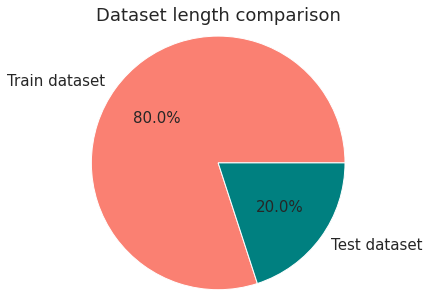

In [8]:
fig, ax = plt.subplots(figsize=(5,5))
pie = ax.pie([len(x_train), len(x_test)],
             labels=["Train dataset", "Test dataset"],
             colors=["salmon", "teal"],
             textprops={"fontsize": 15},
             autopct='%1.1f%%')
ax.axis("equal")
ax.set_title("Dataset length comparison", fontsize=18)
fig.set_facecolor('white')
plt.show();

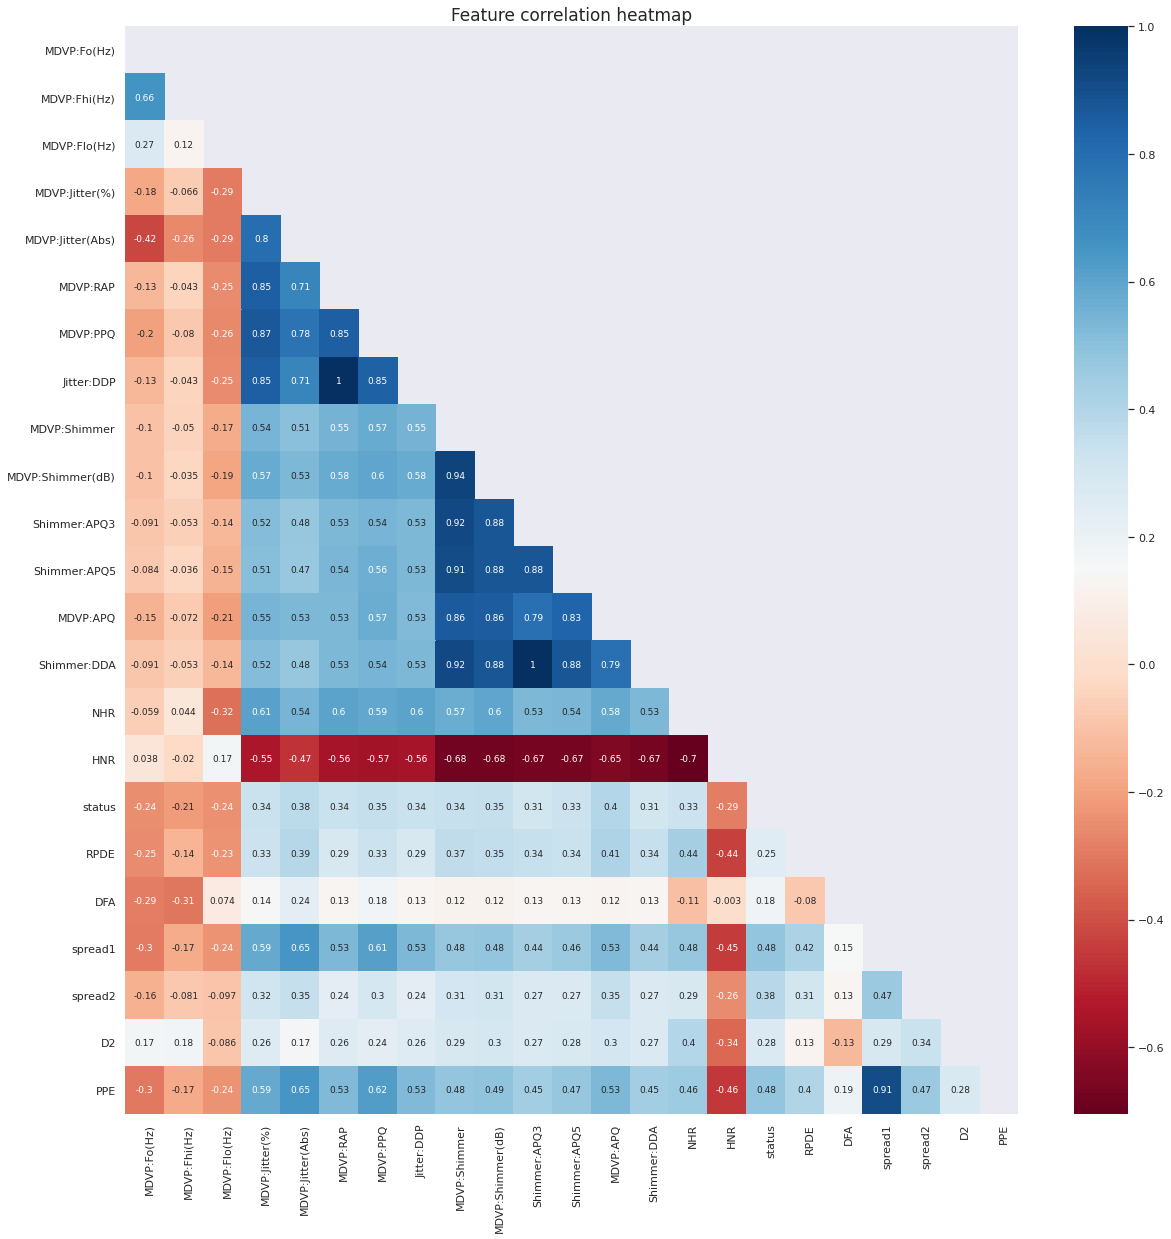

In [9]:
# Calculatin correlation values
df = df.corr(method='kendall').round(3)

# Making a plot
plt.figure(figsize=(20,20))

# Mask to hide upper-right part of plot as it is a duplicate
mask = np.zeros_like(df)
mask[np.triu_indices_from(mask)] = True

ax = sns.heatmap(df, annot=True, mask=mask, cmap="RdBu", annot_kws={"weight": "normal", "fontsize":9})
ax.set_title("Feature correlation heatmap", fontsize=17)
plt.setp(ax.get_xticklabels(), rotation=90, ha="right",
         rotation_mode="anchor", weight="normal")
plt.setp(ax.get_yticklabels(), weight="normal",
         rotation_mode="anchor", rotation=0, ha="right")
plt.show();

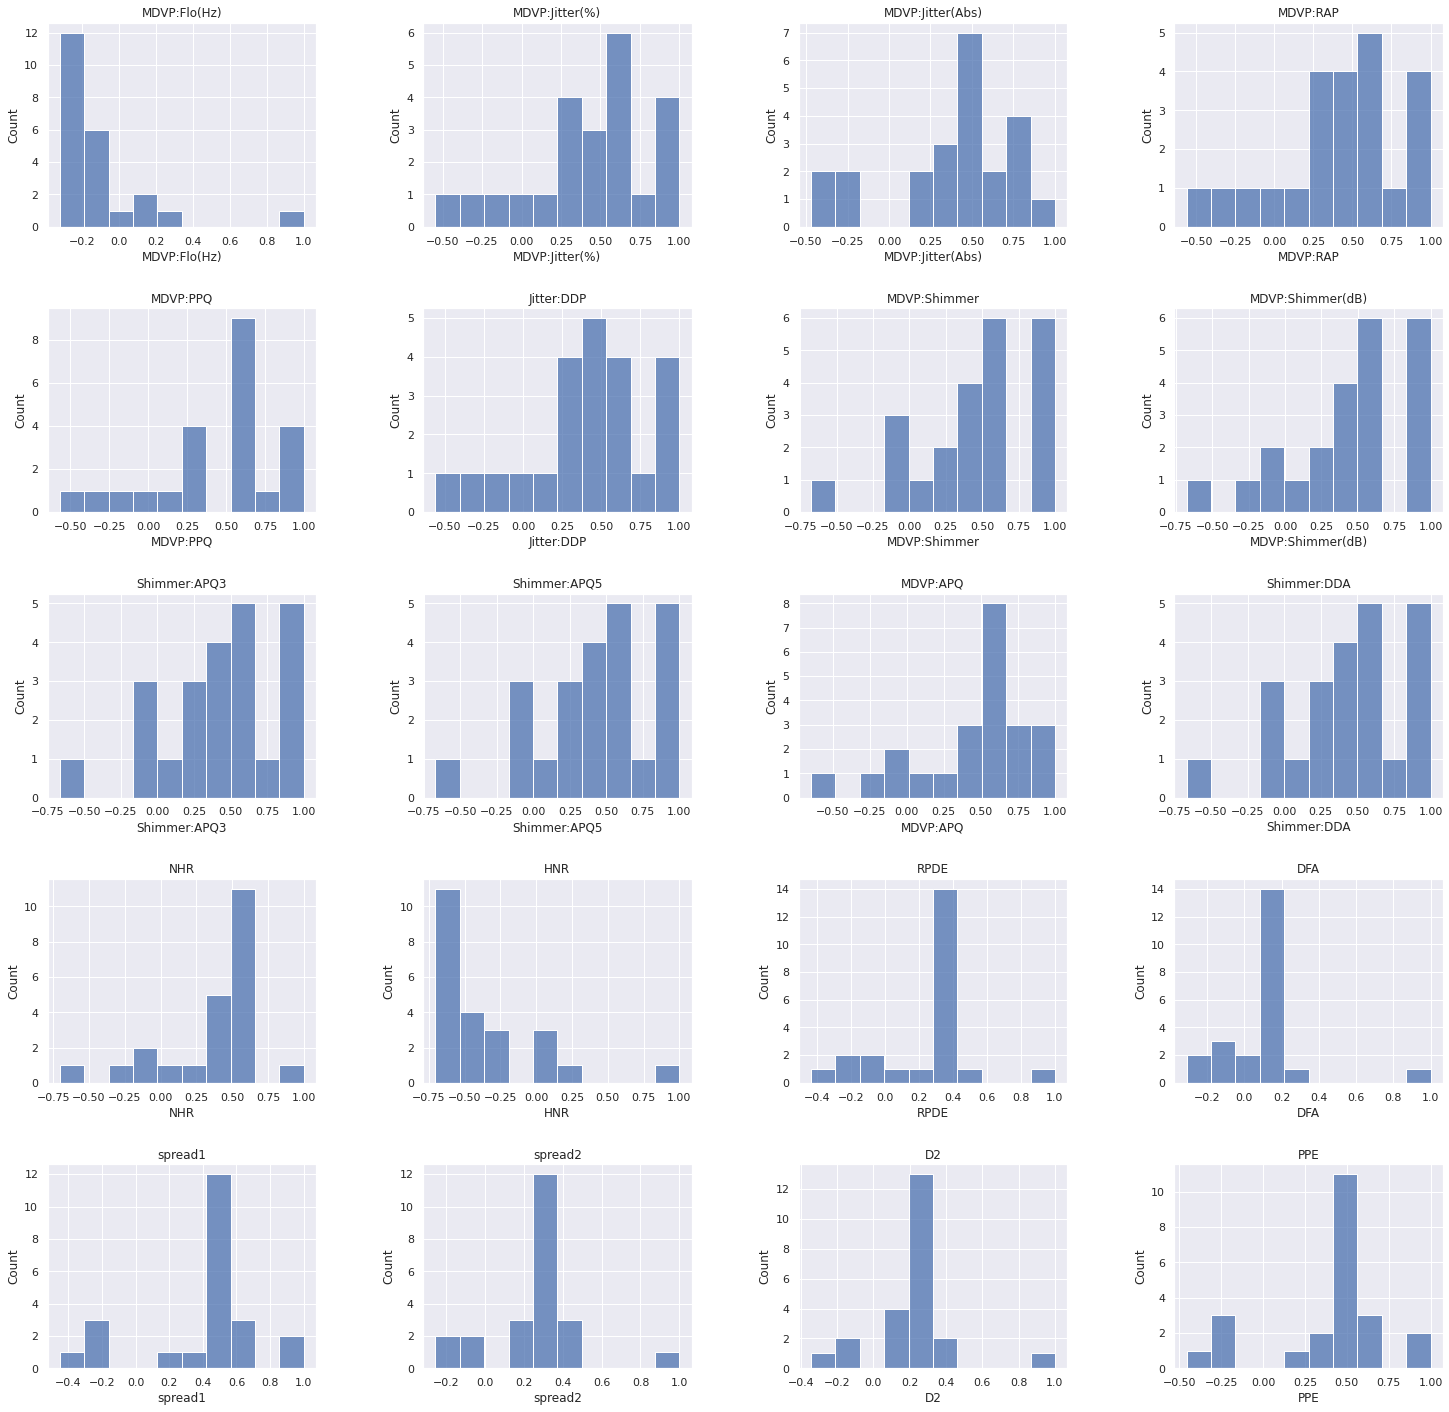

In [25]:
numerical = df.columns.tolist()[2:]
numerical.remove('status')

plt.figure(figsize=(25,30))
plt.subplots_adjust(hspace=0.4, wspace=0.4)
for i, num_attrib in enumerate(numerical):
    plt.subplot(6, 4, i+1)
    sns.histplot(df[num_attrib], bins=10)
    plt.title(num_attrib)
plt.show()

# **XGBClassifier** - (from tutorial)

In [11]:
# Train the model
model = XGBClassifier() # we assign the model into a variable, now is ready to be train
model.fit(x_train,y_train) # we train the model with the "train data" separated previously

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [12]:
# Calculate the accuracy
y_pred = model.predict(x_test) # then we calculate the prediction of our model on unseen data

# and get an accuracy score based on the prediction in train data and test data
print(accuracy_score(y_test, y_pred)*100)

94.87179487179486


# **Baggin Algorithm using RandomForestClassifier**


In [13]:
# generating the classificator model, using cross validation
ranfo = RandomForestClassifier(n_estimators=100,max_samples=0.3,
                             max_features=0.3,oob_score=True)

Kfold = KFold(n_splits=10)

result = cross_val_score(ranfo, x_train,y_train,cv=Kfold) 

In [14]:
print("CrossValidation score es %0.2f%% +/- %0.2f%%" %(result.mean()*100,result.std()*100))

CrossValidation score es 84.67% +/- 4.85%


In [15]:
# Review the best model
ranfo.fit(x_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=0.3,
                       max_leaf_nodes=None, max_samples=0.3,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=True, random_state=None,
                       verbose=0, warm_start=False)

### **Feature Importance**

We could also state the importance of certain variables for the prediction of our target.

In [16]:
# Using Impurity

feature_names = [f'feature {i}' for i in range(x_train.shape[1])]
importances = ranfo.feature_importances_
std = np.std([tree.feature_importances_ for tree in ranfo.estimators_], axis=0)

Text(0, 0.5, 'Average Lower accuracy')

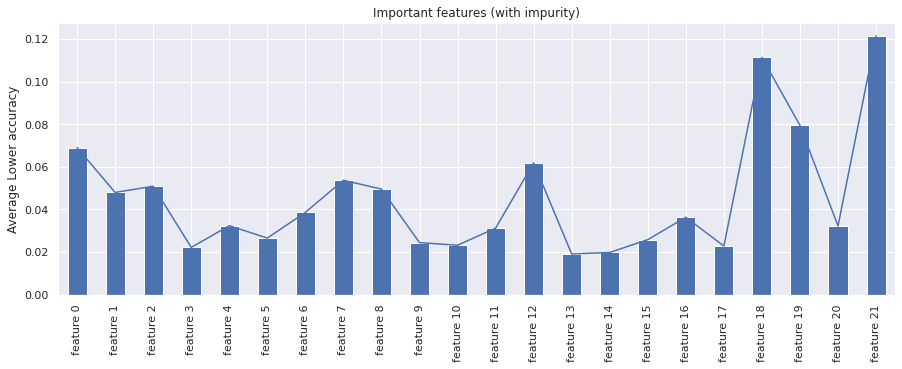

In [17]:
# The most important variables in the df

forest_importances1 = pd.Series(importances, index=feature_names)

forest_importances1.plot(figsize=(15,5))
forest_importances1.plot.bar()

plt.title("Important features (with impurity)")
plt.ylabel("Average Lower accuracy") 

Text(0, 0.5, 'Average Lower accuracy')

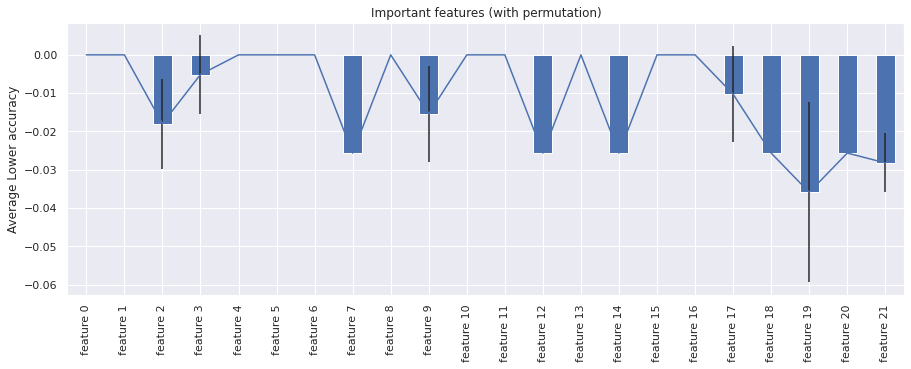

In [18]:
# Using Permutation

result2 = permutation_importance(ranfo, x_test, y_test,scoring= 'accuracy' ,n_repeats=10)

# grafico de variables importantes
forest_importances2 = pd.Series(result2.importances_mean, index=feature_names)

forest_importances2.plot(figsize=(15,5))
forest_importances2.plot.bar(yerr=result2.importances_std)

plt.title("Important features (with permutation)")
plt.ylabel("Average Lower accuracy") 

In [19]:
print("Train\n",classification_report(y_train,ranfo.predict(x_train)))
print("Test\n",classification_report(y_test,ranfo.predict(x_test)))

Train
               precision    recall  f1-score   support

           0       1.00      0.85      0.92        41
           1       0.95      1.00      0.97       115

    accuracy                           0.96       156
   macro avg       0.98      0.93      0.95       156
weighted avg       0.96      0.96      0.96       156

Test
               precision    recall  f1-score   support

           0       0.75      0.43      0.55         7
           1       0.89      0.97      0.93        32

    accuracy                           0.87        39
   macro avg       0.82      0.70      0.74        39
weighted avg       0.86      0.87      0.86        39



Text(0.5, 1.0, 'ROC comparison')

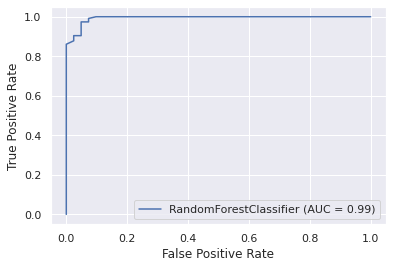

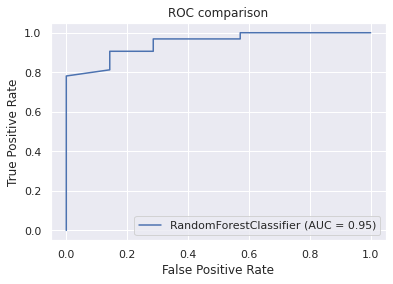

In [20]:
from sklearn.metrics import plot_roc_curve

import matplotlib.pyplot as plt

plot_roc_curve(ranfo, x_train,y_train)
print("")
plot_roc_curve(ranfo, x_test,y_test)

plt.title("ROC comparison")

In [21]:
# Bagging Report
print("Train score ranfo:\t", round(ranfo.score(x_train, y_train),3))
print("Test score ranfo:\t", round(ranfo.score(x_test, y_test),3))

Train score ranfo:	 0.962
Test score ranfo:	 0.872


In [22]:
# errores y oobs
print('Training Score: %.2f \nTest Score: %.2f \nOOB Score: %.2f'%(ranfo.score(x_train, y_train), ranfo.score(x_test, y_test),ranfo.oob_score_))

Training Score: 0.96 
Test Score: 0.87 
OOB Score: 0.85


In [23]:
print("Train\n",confusion_matrix(y_train,ranfo.predict(x_train)))
print()
print("Test\n",confusion_matrix(y_test,ranfo.predict(x_test)))

Train
 [[ 35   6]
 [  0 115]]

Test
 [[ 3  4]
 [ 1 31]]
